In [3]:
import pandas as pd
import numpy as np
import math
from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate, dot, multiply, add
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import *
from keras import backend as K
from keras import losses
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from clr import CyclicLR
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import gc
from sklearn import model_selection
import tensorflow as tf
import sys
from keras.layers.noise import GaussianNoise
import bcolz

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [4]:
def log_prices(data):
    prices = data.price.as_matrix()
    prices = np.log1p(prices)
    prices[prices==-np.inf] = -1
    return prices

In [5]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred))) 

In [6]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

In [7]:
def tokenizer_fit(col, df_train, df_test):
    tokenizer = Tokenizer(filters='', lower=False, split='뷁', oov_token='oov')
    tokenizer.fit_on_texts(df_train[col])
    train_sequences = np.array(tokenizer.texts_to_sequences(df_train[col]))
    test_sequences = np.array(tokenizer.texts_to_sequences(df_test[col]))
    
    return train_sequences, test_sequences, tokenizer

In [8]:
def group_target_by_fields(df, target, cols = None):
    if cols is None:
        cols = df.columns
    
    mean_dicts = {}
    std_dicts = {}
    
    target_mean = df[target].mean()
    target_std = df[target].std()
    
    for c in cols:
        gp = df.groupby(c)[target]
        mean = gp.mean()
        std  = gp.std()
        
        
        if pd.DataFrame(mean).isnull().values.any():
            mean = mean.fillna(target_mean)
            
        if pd.DataFrame(std).isnull().values.any():
            std = std.fillna(target_std)
            
        df[c + '_' + target + '_avg'] = df[c].map(mean)
        df[c + '_' + target + '_std'] = df[c].map(std)
        
        mean_dicts[c] = mean.to_dict()
        std_dicts[c] = std.to_dict()
        
    return mean_dicts, std_dicts

In [9]:
def do_feature_engineering(df, text_features, cat_features):
    for col in text_features:
        df[col] = df[col].str.lower()
        df[col] = df[col].str.replace("[^[:alpha:]]", " ")
        df[col] = df[col].str.replace("\\s+", " ")
        df[col + '_num_chars'] = df[col].apply(len)
        df[col + '_num_words'] = df[col].apply(lambda comment: len(comment.split()))
        df[col + '_num_unique_words'] = df[col].apply(lambda comment: len(set(w for w in comment.split())))
        df[col + '_words_vs_unique'] = df[col+'_num_unique_words'] / df[col+'_num_words'] * 100

    return group_target_by_fields(df, target='deal_probability', cols=cat_features)

In [10]:
def plot_lr(history):
    plt.ylabel("loss")
    plt.xlabel("learning rate")
    plt.plot(history['lr'], history['loss'])
    plt.show()

In [11]:
def append_text_features(X, descr_features, title_features, params_features, descr_repeat_times=1,
                         title_repeat_times=1, params_repeat_times=1, idx=None):
        
    for i in range(descr_repeat_times):
        X.append(descr_features[idx])
    
    for i in range(title_repeat_times):
        X.append(title_features[idx])
        
    for i in range(params_repeat_times):
        X.append(params_features[idx])

In [12]:
def exp_decay(epoch):
    initial_lrate = learning_rate
    k = 0.1
    lrate = initial_lrate * math.exp(-k*epoch)
    print(lrate)
    
    return lrate

In [54]:
def get_model():
    K.clear_session()
    inp_region = Input(shape=(1, ), name='inp_region')
    emb_region = Embedding(len_region, size_emb_region, name='emb_region')(inp_region)
    emb_region = Reshape(target_shape=(size_emb_region,))(emb_region)
    
    inp_parentcatname = Input(shape=(1, ), name='inp_parent_category_name')
    emb_parentcatname = Embedding(len_parentcatname, size_emb_parentcatname, name='emb_parent_category_name')(inp_parentcatname)
    emb_parentcatname = Reshape(target_shape=(size_emb_parentcatname,))(emb_parentcatname)
    
    inp_catname = Input(shape=(1, ), name='inp_category_name')
    emb_catname = Embedding(len_catname, size_emb_catname, name="emb_category_name")(inp_catname)
    emb_catname = Reshape(target_shape=(size_emb_catname,))(emb_catname)
    
    inp_usertype = Input(shape=(1, ), name='inp_user_type')
    emb_usertype = Embedding(len_usertype, size_emb_usertype, name='emb_user_type')(inp_usertype)
    emb_usertype = Reshape(target_shape=(size_emb_usertype,))(emb_usertype)
        
    inp_city = Input(shape=(1, ), name='inp_city')
    emb_city = Embedding(len_city, size_emb_city, name='emb_city')(inp_city)
    emb_city = Reshape(target_shape=(size_emb_city,))(emb_city)
    
    inp_week = Input(shape=(1, ), name='inp_week')
    emb_week = Embedding(len_week, size_emb_week, name='emb_week')(inp_week)
    emb_week = Reshape(target_shape=(size_emb_week,))(emb_week)
    
    inp_day = Input(shape=(1, ), name='inp_day_of_month')
    emb_day = Embedding(len_day_month, size_emb_day_month, name='emb_day_of_month')(inp_day)
    emb_day = Reshape(target_shape=(size_emb_day_month,))(emb_day)
    
    inp_imgt1 = Input(shape=(1, ), name='inp_imgt1')
    emb_imgt1 = Embedding(len_imgt1, size_emb_imgt1, name='emb_imgt1')(inp_imgt1)
    emb_imgt1 = Reshape(target_shape=(size_emb_imgt1,))(emb_imgt1)
    
    inp_price = Input(shape=(1, ), name='inp_price')
    #x = GaussianNoise(1)(inp_price)
    #emb_price = Dense(size_emb_price, activation='tanh', name='emb_price')(x)

    inp_itemseq = Input(shape=(1, ), name='inp_itemseq')
    #emb_itemseq = Dense(size_emb_itemseq, activation='tanh', name='emb_itemseq')(inp_itemseq)
    
    #inp_feat_eng = Input(shape=(len_feat_eng, ), name='inp_feat_eng')
    #x = GaussianNoise(1)(inp_feat_eng)
    #emb_feat_eng = Dense(size_emb_feat_eng, activation='tanh', name='emb_feat_eng')(x)
    
    conc_cat_and_cont = concatenate([emb_region, emb_parentcatname, emb_catname, emb_usertype, emb_city, emb_week, 
                             emb_day, emb_imgt1, inp_price, inp_itemseq], axis=-1, name='concat_cat_and_cont')
    
#     x = Dropout(dropout)(conc_cat_and_cont)
#     x = Dense(25, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
#     conc_cat_and_cont = Dense(25, activation='relu')(x)
    

    
    ### title
    # channel 1
   
    embedding = Embedding(vocabulary_size, size_emb_title, name='emb_title_1')
    
#     input_title_1 = Input(shape=(maxlen_title,), name='input_title_1')
#     embedding_for_title = embedding(input_title_1)
#     x = Dropout(dropout)(embedding_for_title)
#     x = GRU(5, dropout=dropout, recurrent_dropout=dropout, return_sequences=True)(x)
#     title_layer = GRU(5, dropout=dropout, recurrent_dropout=dropout, return_sequences=False)(x)
    
    
    #x = BatchNormalization()(x)
    #x = Dropout(dropout)(x)
    #x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(dropout)(x)
    #x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
    #avg_pool = GlobalAveragePooling1D()(x)
    #max_pool = GlobalMaxPooling1D()(x)
    #title_layer = concatenate([avg_pool, max_pool])
    
    input_descr_1 = Input(shape=(maxlen_description, ), name='inp_descr_1')
    embedding_for_descr = embedding(input_descr_1)
    #x = Dropout(dropout)(embedding_for_descr)
    descr_layer = GRU(50)(embedding_for_descr)
    # = GRU(5, dropout=dropout, recurrent_dropout=dropout, return_sequences=False)(x)
    
#     x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
#     #x = BatchNormalization()(x)
#     #x = Dropout(dropout)(x)
#     #x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#    descr_layer = concatenate([avg_pool, max_pool])
    
#     input_params_1 = Input(shape=(maxlen_params, ), name='inp_params_1')
#     embedding_for_params = embedding(input_params_1)
#     x = Dropout(dropout)(embedding_for_params)
#     x = GRU(5, dropout=dropout, recurrent_dropout=dropout, return_sequences=True)(x)
#     params_layer = GRU(5, dropout=dropout, recurrent_dropout=dropout, return_sequences=False)(x)
    
#     x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
#     #x = BatchNormalization()(x)
#     #x = Dropout(dropout)(x)
#     #x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     params_layer = concatenate([avg_pool, max_pool])
#     max_pool = GlobalMaxPooling1D()(x)
#     title_layer = concatenate([avg_pool, max_pool])     # channel 2
#     input_title_2 = Input(shape=(maxlen_title,), name='input_title_2')
#     embedding2 = Embedding(title_vocabulary_size, size_emb_title, weights = [embedding_matrix_title], trainable=False, name='emb_title_2')(input_title_2)

#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=128, kernel_size=2, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=256, kernel_size=4, activation='relu')(x)
#     
    # channel 3
#     input_title_3 = Input(shape=(maxlen_title,), name='input_title_3')
#     embedding3 = Embedding(title_vocabulary_size, size_emb_title, weights = [embedding_matrix_title], trainable=False, name='emb_title_3')(input_title_3)
#     x = Dropout(dropout)(embedding3)
#     x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=128, kernel_size=4, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=256, kernel_size=5, activation='relu')(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc3 = concatenate([avg_pool, max_pool])#     # merge
     
#     merged = concatenate([conc1, conc2, conc3])
#     # interpretation
    #x = Dropout(dropout)(x)
    #title_layer = Dense(50, activation='relu')(x)
    
    ### params
    # channel 1
#     input_params_1 = Input(shape=(maxlen_params,), name='input_params_1')
#     embedding1 = Embedding(params_vocabulary_size, size_emb_params, name='emb_params_1')(input_params_1)
#     x = SpatialDropout1D(spatial_dropout)(embedding1)
#     #x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
#     #x = Bidirectional(GRU(40, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))(x)
#     #x = BatchNormalization()(x)
#     x = Conv1D(filters=80, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.5))(x)
#     x = Dropout(dropout)(x)
#     x = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.5))(x)
#     #x = Bidirectional(GRU(40, return_sequences=True, dropout=dropout))(x)
#     #x = SpatialDropout1D(spatial_dropout)(x)
#     #x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
#     #x = Bidirectional(GRU(40, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])    
#     # channel 2
#     input_params_2 = Input(shape=(maxlen_params,), name='input_params_2')
#     embedding2 = Embedding(params_vocabulary_size, size_emb_params, weights = [embedding_matrix_params], trainable=False, name='emb_params_2')(input_params_2)
#     x = SpatialDropout1D(spatial_dropout)(embedding2)
#     x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=256, kernel_size=4, activation='relu')(x)
#     flat2 = GlobalMaxPool1D(name='global_max_pooling_params_2')(x)
#     # channel 3
#     input_params_3 = Input(shape=(maxlen_params,), name='input_params_3')
#     embedding3 = Embedding(params_vocabulary_size, size_emb_params, weights = [embedding_matrix_params], trainable=False, name='emb_params_3')(input_params_3)
#     x = SpatialDropout1D(spatial_dropout)(embedding3)
#     x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=128, kernel_size=4, activation='relu')(x)
#     x = SpatialDropout1D(spatial_dropout)(x)
#     x = Conv1D(filters=256, kernel_size=5, activation='relu')(x)
#     flat3 = GlobalMaxPool1D(name='global_max_pooling_params_3')(x)
#     # merge
#     merged = concatenate([flat1, flat2, flat3])
    # interpretation
    #x = BatchNormalization()(conc)
#     x = Dropout(dropout)(conc)
#     params_layer = Dense(20, activation='relu')(x)
    
#     inp_params= Input(shape=(maxlen_params, ), name='inp_params')
#     emb_params = Embedding(params_vocabulary_size, size_emb_params, name='emb_params')(inp_params)

#     params_layer = GRU(40, return_sequences=True)(emb_params)


    #img_features
    #input_img = Input(shape=(number_img_features,), name='input_img')


    conc_all = concatenate([conc_cat_and_cont, descr_layer], axis=-1)
    
    
    ###
    #x = Dropout(dropout)(conc_all)
    x = Dense(500, activation='relu')(conc_all)
    #x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs = [inp_region, inp_parentcatname, inp_catname, inp_usertype, inp_city, inp_week, inp_day, inp_imgt1, inp_price, inp_itemseq,
                            input_descr_1, #input_descr_2, input_descr_3,
                            #inp_descr,
                            #input_title_1, #input_title_2, input_title_3,
                            #input_params_1,# input_params_2, input_params_3,
                            #input_img
                           ], outputs = y)
    
    return model

In [14]:
PATH = "/home/axel/Desktop/kaggle/avito/"
EMBEDDING_FILE = PATH + 'train/cc.ru.300.vec'

In [15]:
df_train = pd.read_csv(f'{PATH}train/train.csv', parse_dates=['activation_date'])
df_test  = pd.read_csv(f'{PATH}test/test.csv', parse_dates=['activation_date'])

df_train.sort_values(by=['image'], inplace=True)
df_test.sort_values(by=['image'], inplace=True)

In [17]:
stop_words = set(stopwords.words('russian'))

In [18]:
stop_words = set([word.lower() for word in stop_words])

In [19]:
# d = df_train.as_matrix()
# d = d[:1390832]
# df_train = pd.DataFrame(d, columns=df_train.columns)

In [20]:
#df_train.to_csv(f'{PATH}train/train2.csv')

In [21]:
df_train['image_top_1'].fillna(value=3067, inplace=True)
df_test['image_top_1'].fillna(value=3067, inplace=True)

df_train['description'].fillna(value='_NA_', inplace=True)
df_test['description'].fillna(value='_NA_', inplace=True)

df_train['params'] = df_train.apply(lambda row: ' '.join([
                        str(row['param_1']), 
                        str(row['param_2']), 
                        str(row['param_3'])]), axis=1)

df_test['params'] = df_test.apply(lambda row: ' '.join([
                        str(row['param_1']), 
                        str(row['param_2']), 
                        str(row['param_3'])]),axis=1)

df_train['params'].fillna(value='_NA_', inplace=True)
df_test['params'].fillna(value='_NA_', inplace=True)

df_train['price'].fillna(value=-1.0, inplace=True)
df_test['price'].fillna(value=-1.0, inplace=True)

df_train['title'] = df_train['title'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))
df_train['description'] = df_train['description'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))
df_train['params'] = df_train['params'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))

df_test['title'] = df_test['title'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))
df_test['description'] = df_test['description'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))
df_test['params'] = df_test['params'].str.split(' ').apply(lambda row: ' '.join([word.lower() for word in row if word.lower() not in stop_words]))

In [22]:
df_train['weekday'] = df_train['activation_date'].dt.weekday
df_train["day_of_month"] = df_train['activation_date'].dt.day


df_test['weekday'] = df_test['activation_date'].dt.weekday
df_test["day_of_month"] = df_test['activation_date'].dt.day

In [23]:
train_region, test_region, tokenizer_region = tokenizer_fit('region', df_train, df_test)
train_parentcatname, test_parentcatname, tokenizer_parentcatname = tokenizer_fit('parent_category_name', df_train, df_test)
train_catname, test_catname, tokenizer_catname = tokenizer_fit('category_name', df_train, df_test)
train_usertype, test_usertype, tokenizer_usertype = tokenizer_fit('user_type', df_train, df_test)
train_city, test_city, tokenizer_city = tokenizer_fit('city', df_train, df_test)
train_params, test_params, tokenizer_params = tokenizer_fit('params', df_train, df_test)

In [24]:
train_week = df_train['weekday'].astype(np.int32).values
test_week = df_test['weekday'].astype(np.int32).values

train_day_of_month = df_train['day_of_month'].astype(np.int32).values
test_day_of_month = df_test['day_of_month'].astype(np.int32).values

In [25]:
train_week = np.expand_dims(train_week, axis=-1)
test_week = np.expand_dims(test_week, axis=-1)

train_day_of_month = np.expand_dims(train_day_of_month, axis=-1)
test_day_of_month = np.expand_dims(test_day_of_month, axis=-1)

In [26]:
train_imgtop1 = df_train['image_top_1'].astype(np.int32).values
test_imgtop1 = df_test['image_top_1'].astype(np.int32).values
train_imgtop1 = np.expand_dims(train_imgtop1, axis=-1)
test_imgtop1 = np.expand_dims(test_imgtop1, axis=-1)

In [27]:
eps = 1e-10
train_price = np.log(df_train['price']+eps)
test_price = np.log(df_test['price']+eps)
train_price = train_price.fillna(-1.)
test_price = test_price.fillna(-1.)

train_price = np.expand_dims(train_price, axis=-1)
test_price = np.expand_dims(test_price, axis=-1)

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
train_itemseq = np.log(df_train['item_seq_number'])
test_itemseq = np.log(df_test['item_seq_number'])

train_itemseq = np.expand_dims(train_itemseq, axis=-1)
test_itemseq = np.expand_dims(test_itemseq, axis=-1)

In [29]:
vocabulary_size = 10000

tokenizer_title_desc = Tokenizer(num_words=vocabulary_size, lower='True')
tokenizer_title_desc.fit_on_texts(np.append(df_train['title'].values, [df_train['description'].values, df_train['params'].values]))


train_title_seq = tokenizer_title_desc.texts_to_sequences(df_train['title'].values)
test_title_seq = tokenizer_title_desc.texts_to_sequences(df_test['title'].values)

train_desc_seq = tokenizer_title_desc.texts_to_sequences(df_train['description'].values)
test_desc_seq = tokenizer_title_desc.texts_to_sequences(df_test['description'].values)

train_params_seq = tokenizer_title_desc.texts_to_sequences(df_train['params'].values)
test_params_seq = tokenizer_title_desc.texts_to_sequences(df_test['params'].values)

maxlen_description = 50
train_desc_pad = pad_sequences(train_desc_seq, maxlen=maxlen_description)
test_desc_pad = pad_sequences(test_desc_seq, maxlen=maxlen_description)

maxlen_title = 30
train_title_pad = pad_sequences(train_title_seq, maxlen=maxlen_title)
test_title_pad = pad_sequences(test_title_seq, maxlen=maxlen_title)

maxlen_params = 30
train_params_pad = pad_sequences(train_params_seq, maxlen=maxlen_params)
test_params_pad = pad_sequences(test_params_seq, maxlen=maxlen_params)

In [30]:
# descr_vocabulary_size = 10000

# tokenizer_desc = Tokenizer(num_words=descr_vocabulary_size, lower='True')
# tokenizer_desc.fit_on_texts(df_train['description'].values)

# train_desc_seq = tokenizer_desc.texts_to_sequences(df_train['description'].values)
# test_desc_seq = tokenizer_desc.texts_to_sequences(df_test['description'].values)

# maxlen_description = 100
# train_desc_pad = pad_sequences(train_desc_seq, maxlen=maxlen_description)
# test_desc_pad = pad_sequences(test_desc_seq, maxlen=maxlen_description)

In [31]:
# title_vocabulary_size = 10000

# tokenizer_title = Tokenizer(num_words=title_vocabulary_size, lower='True')
# tokenizer_title.fit_on_texts(df_train['title'].values)

# train_title_seq = tokenizer_title.texts_to_sequences(df_train['title'].values)
# test_title_seq = tokenizer_title.texts_to_sequences(df_test['title'].values)

# maxlen_title = 30
# train_title_pad = pad_sequences(train_title_seq, maxlen=maxlen_title)
# test_title_pad = pad_sequences(test_title_seq, maxlen=maxlen_title)

In [32]:
# params_vocabulary_size = 10000

# tokenizer_params = Tokenizer(num_words=params_vocabulary_size, lower='True')
# tokenizer_params.fit_on_texts(df_train['params'].values)

# train_params_seq = tokenizer_params.texts_to_sequences(df_train['params'].values)
# test_params_seq = tokenizer_params.texts_to_sequences(df_test['params'].values)

# maxlen_params = 30
# train_params_pad = pad_sequences(train_params_seq, maxlen=maxlen_params)
# test_params_pad = pad_sequences(test_params_seq, maxlen=maxlen_params)

In [33]:
feat_eng_cols = [c for c in df_train.columns if c.endswith('_avg') or c.endswith('_std')]

## categorical
len_region = len(tokenizer_region.word_index)
len_parentcatname = len(tokenizer_parentcatname.word_index)
len_catname = len(tokenizer_catname.word_index) 
len_usertype = len(tokenizer_usertype.word_index)
len_city = len(tokenizer_city.word_index) + 1
len_week = 7
len_day_month = int(df_train['day_of_month'].max()) + 1
len_imgt1 = int(df_train['image_top_1'].max()) + 1

## continuous
len_price = 1
len_itemseq = 1
len_feat_eng = len(feat_eng_cols)

In [43]:
## categorical
size_emb_region = 8
size_emb_parentcatname = 4
size_emb_catname = 8
size_emb_usertype = 2
size_emb_city = 16
size_emb_week = 4
size_emb_day_month = 10
size_emb_imgt1 = 30

#continuous
size_emb_price = 1
size_emb_itemseq = 16
size_emb_feat_eng = 10


#text
size_emb_desc = 50
size_emb_title = 50
size_emb_params = 50

#dropout
spatial_dropout = 0.5
dropout = 0.1

In [35]:
#train_idx = df_train[df_train.activation_date < '2017-03-27'].index
#val_idx = df_train[(df_train.activation_date >= '2017-03-27') & (df_train.activation_date <= '2017-04-07')].index
test_idx = df_test.index.values

In [36]:
val_idx = df_train[:1390832].sample(frac=0.2).index
train_idx = df_train[:1390832][np.invert(df_train[:1390832].index.isin(val_idx))].index

In [37]:
len(train_idx)

1112666

In [38]:
len(val_idx)

278166

In [39]:
#len(df_train[:1390832]['image'])

In [40]:
X = np.array([train_region, train_parentcatname, train_catname, train_usertype, train_city, train_week, train_day_of_month, train_imgtop1,
              train_price, train_itemseq])

X_test = np.array([test_region, test_parentcatname, test_catname, test_usertype, test_city, test_week, test_day_of_month, test_imgtop1,
                   test_price, test_itemseq])

Y = df_train['deal_probability']

In [41]:
X_train = [x[train_idx] for x in X]
X_valid = [x[val_idx] for x in X]
X_test = [x for x in X_test]

y_train = np.expand_dims(Y[train_idx].ravel(), axis=-1)
y_valid = np.expand_dims(Y[val_idx].ravel(), axis=-1)

In [20]:
text_features = ["description", "params", "title"]

cat_features = ['region', 'city', 'parent_category_name', 'category_name',
                 'image_top_1', 'user_type','item_seq_number','weekday', 'day_of_month']

mean_dicts, std_dicts = do_feature_engineering(df_train, text_features, cat_features)

In [21]:
for c in df_train.columns:
    if c.endswith('_avg'):
        X_valid[c] = X_valid[c[:-20]].map(mean_dicts[c[:-20]])
        X_test[c] = X_test[c[:-20]].map(mean_dicts[c[:-20]])
    if c.endswith('_std'):
        X_valid[c] = X_valid[c[:-20]].map(std_dicts[c[:-20]])
        df_test[c] = X_test[c[:-20]].map(std_dicts[c[:-20]])

In [39]:
feat_eng_train = []
feat_eng_test = []

for row in X_train[feat_eng_cols].iterrows():
    index, data = row
    feat_eng_train.append(data.tolist())
    
#for row in df_test[feat_eng_cols].iterrows():
#    index, data = row
#    feat_eng_test.append(data.tolist())

In [40]:
feat_eng_train = np.array(feat_eng_train)
feat_eng_test = np.array(feat_eng_test)

In [43]:
X_train.append(feat_eng_train[train_idx])
X_valid.append(feat_eng_train[val_idx])
X_test.append(feat_eng_test[test_idx])

In [42]:
append_text_features(X_train, train_desc_pad, train_title_pad, train_params_pad, 
                     title_repeat_times=0, descr_repeat_times=1, params_repeat_times=0, idx=train_idx)
append_text_features(X_valid, train_desc_pad, train_title_pad, train_params_pad,
                     title_repeat_times=0, descr_repeat_times=1, params_repeat_times=0, idx=val_idx)
append_text_features(X_test, test_desc_pad, test_title_pad, test_params_pad,
                     title_repeat_times=0, descr_repeat_times=1, params_repeat_times=0, idx=test_idx)

In [46]:
# count_title_descr.fit(np.append(df_train['title'].values, df_train['description'].values))

In [47]:
# tokenizer_title_desc_test = Tokenizer(num_words=vocabulary_size, lower='True')
# tokenizer_title_desc_test.fit_on_texts(np.append(df_test['title'].values, [df_test['description'].values, df_test['params'].values]))


In [48]:
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

In [49]:
# embedding_matrix_descr = np.zeros((descr_vocabulary_size, size_emb_desc))
# embedding_matrix_title = np.zeros((title_vocabulary_size, size_emb_title))
# embedding_matrix_params = np.zeros((params_vocabulary_size, size_emb_params))

In [50]:
# for word, i in tqdm(tokenizer_desc.word_index.items()):
#     if i >= maxlen_description: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: 
#         embedding_matrix_descr[i] = embedding_vector

# for word, i in tqdm(tokenizer_title.word_index.items()):
#     if i >= maxlen_title: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: 
#         embedding_matrix_title[i] = embedding_vector

# for word, i in tqdm(tokenizer_params.word_index.items()):
#     if i >= maxlen_params: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: 
#         embedding_matrix_params[i] = embedding_vector

In [51]:
#tokenizer_title.texts_to_matrix(df_train['title'].values, mode='tfidf')

In [14]:
IMG_PATH = '/media/axel/ssd/'

img_features_train = bcolz.open(IMG_PATH + 'train/data/competition_files/')[:]
#img_features_test = sparse.load_npz(f'{PATH}/test/test_features.npz')

0

In [49]:
img_feat

Int64Index([ 758131, 1389902,  124417, 1016335,  948889,  790945, 1198053,
             320887, 1229586,  870541,
            ...
            1116590, 1057196,  779540,  148442, 1011959, 1228640, 1113642,
              25987,  236711,   79352],
           dtype='int64', length=1112666)

In [53]:
len(df_train[:1390832])

1390832

In [51]:
len(img_features_train)

1390832

In [18]:
i = pd.DataFrame(img_features_train)

In [19]:
i.set_index(df_train[:1390832].index, inplace=True)

In [20]:
#i.to_csv(f'{PATH}train/img_features.csv')

In [ ]:
img_features_train = pd.read_csv(f'{PATH}train/img_features.csv')

In [58]:
#del i; gc.collect()

93

In [63]:
# i.as_matrix()

array([[0.3447 , 0.498  , 0.     , ..., 0.     , 0.03052, 0.     ],
       [0.10443, 0.0499 , 0.1833 , ..., 0.01449, 0.04538, 0.     ],
       [1.23   , 1.605  , 0.     , ..., 0.01643, 0.     , 0.     ],
       ...,
       [0.3606 , 0.9404 , 0.     , ..., 0.1284 , 0.03296, 0.08215],
       [0.     , 0.     , 0.6465 , ..., 0.     , 0.     , 0.861  ],
       [0.     , 0.2366 , 0.     , ..., 0.06415, 0.     , 0.     ]],
      dtype=float16)

In [17]:
from sklearn.decomposition import TruncatedSVD

number_img_features = 500

svd_img_features = TruncatedSVD(n_components=number_img_features, algorithm='arpack')
svd_img_features.fit(img_features_train.as_matrix())

MemoryError: 

In [ ]:
# svd_img_features.explained_variance_ratio_.sum()

In [47]:
# train_img_features = np.array(svd_img_features.transform(img_features_train), dtype=np.float16)

In [51]:
X_train.append(i.ix[train_idx])

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [55]:
X_valid.append(i.ix[val_idx])

In [55]:
gc.collect()

363

In [55]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_region (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
inp_parent_category_name (Input (None, 1)            0                                            
__________________________________________________________________________________________________
inp_category_name (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
inp_user_type (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
inp_city (

In [57]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [83]:
model = get_model()

In [59]:
batch_size = 2500
learning_rate = 0.0001

In [60]:
model.compile(optimizer=Adam(), loss = root_mean_squared_error)
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

early = EarlyStopping(patience=4, mode='min')
reduce_lr =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
lrate_exp = LearningRateScheduler(exp_decay)
clr = CyclicLR(mode='exp_range', base_lr=0.0001, max_lr=0.1)

callbacks = [checkpoint, early, reduce_lr]


model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=30, callbacks=callbacks, verbose=1)
    

Train on 1112666 samples, validate on 278166 samples
Epoch 1/30
1112666/1112666 [==============================] - 29s 26us/step - loss: 0.2636 - val_loss: 0.2607

Epoch 00001: val_loss improved from inf to 0.26071, saving model to best.hdf5
Epoch 2/30
1112666/1112666 [==============================] - 25s 22us/step - loss: 0.2612 - val_loss: 0.2605

Epoch 00002: val_loss improved from 0.26071 to 0.26053, saving model to best.hdf5
Epoch 3/30
1112666/1112666 [==============================] - 25s 22us/step - loss: 0.2605 - val_loss: 0.2610

Epoch 00003: val_loss did not improve from 0.26053
Epoch 4/30
1112666/1112666 [==============================] - 24s 22us/step - loss: 0.2597 - val_loss: 0.2613

Epoch 00004: val_loss did not improve from 0.26053
Epoch 5/30
1112666/1112666 [==============================] - 25s 22us/step - loss: 0.2578 - val_loss: 0.2634

Epoch 00005: val_loss did not improve from 0.26053
Epoch 6/30
1112666/1112666 [==============================] - 25s 22us/step - l

In [326]:
model.load_weights('best.hdf5')

<tf.Tensor 'GatherV2_13:0' shape=(100,) dtype=float32>

In [ ]:
0.2133 / 0.2420 

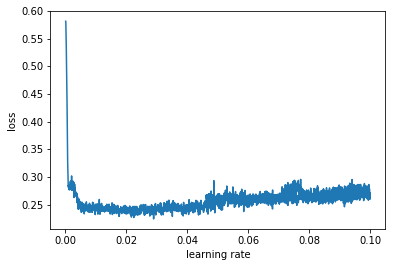

In [116]:
plot_lr(clr.history)

In [171]:
y_pred = model.predict(X_valid, batch_size=batch_size)
y_pred = np.clip(y_pred, 0, 1)

In [172]:
math.sqrt(((y_valid-y_pred)**2).mean())

0.2133922860754405

In [141]:
y_pred.shape

(227848, 1)

In [144]:
sess = tf.Session()

with sess.as_default():
    print(K.sqrt(K.mean(K.square(y_valid - y_pred))).eval())

[ 0.0403143   0.4394172   0.02837736 ...,  0.16886499  0.33733565
  0.13886825]


In [153]:
#model.load_weights('model_baseline_weights.hdf5')
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.clip(y_pred, 0, 1)
df_submission = pd.DataFrame(df_test['item_id'], columns=['item_id'])
df_submission['deal_probability'] = y_pred
df_submission[['item_id','deal_probability']].to_csv('../../../submission.csv', index=False)